In [76]:
import pandas as pd
import numpy as np
import math
import arch
import scipy
import copy
from xgboost import XGBRegressor
import src.feature_extraction
import src.GetPoolData

In [77]:
import pandas as pd
import numpy as np
import scipy
import src.GetPoolData as GetPoolData
import src.ActiveStrategyFramework as ActiveStrategyFramework
import src.ML_Strategy as ML_Strategy
import itertools
import arch
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [78]:
GetPoolData.get_current_state()['data']['pool']['sqrtPrice']

'1654330627754029722840434061152199'

In [79]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create config.py in this directory and enter your own Bitquery API Token
BITQUERY_API_TOKEN = 'BQY0mSI2IadezoknHO3JMzexNwCpugm5'

#################
#
# Download data
#
################
# Get Swap Data
DOWNLOAD_DATA      = False
pool_address       = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
token_0_address    = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
token_1_address    = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'

flipside_queries   = ['https://api.flipsidecrypto.com/api/v2/queries/85a454a3-0f72-470a-bd5b-d39323c376bb/data/latest',
                      'https://api.flipsidecrypto.com/api/v2/queries/6f0aec42-5fb8-41b3-9fc1-7bafcf68a9a2/data/latest',
                      'https://api.flipsidecrypto.com/api/v2/queries/669fc9f7-8b2d-4dd2-948f-668de9eb4e8a/data/latest']

# Price data for theThese must be month ends
price_data_begin         = '2021-12-31'
price_data_end           = '2022-12-'
file_name                = 'eth_usdc'

swap_data  = GetPoolData.get_pool_data_flipside(pool_address,flipside_queries,file_name,DOWNLOAD_DATA)  
price_data = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name,DOWNLOAD_DATA)

In [12]:
DATE_BEGIN                 = pd.to_datetime('2022-01-28 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2022-01-29 00:00PM',utc=True)
z_score_cutoff             = 5
window_size                = 60

# Data for strategy simulation cleaning 
STRATEGY_FREQUENCY                      = 'H'
simulate_data_filtered                   = ActiveStrategyFramework.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size) 
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_price                      = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]


# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
STAT_MODEL_FREQUENCY       = 'H' # forecast returns at a daily frequency

# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*(10**((DECIMALS_1  + DECIMALS_0)/2))
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

In [40]:
simulate_data_filtered

,time,baseCurrency,quoteCurrency,quoteAmount,baseAmount,tradeAmount,quotePrice,price_return,roll_median,median_abs_dev
time_pd,,,,,,,,,,
2021-12-31 00:00:00+00:00,2021-12-31 00:59:00,USDC,WETH,124.972350,4.628055e+05,4.626799e+05,0.000270,NaN,NaN,NaN
2021-12-31 01:00:00+00:00,2021-12-31 01:59:00,USDC,WETH,84.054799,3.133368e+05,3.110562e+05,0.000268,-0.006574,NaN,NaN
2021-12-31 02:00:00+00:00,2021-12-31 02:59:00,USDC,WETH,4.955215,1.840499e+04,1.840509e+04,0.000269,0.003635,NaN,NaN
2021-12-31 03:00:00+00:00,2021-12-31 03:59:00,USDC,WETH,27.520551,1.028719e+05,1.022974e+05,0.000268,-0.006350,NaN,NaN
2021-12-31 04:00:00+00:00,2021-12-31 04:59:00,USDC,WETH,109.177056,4.091628e+05,4.084972e+05,0.000267,-0.002587,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-10 19:00:00+00:00,2022-04-10 19:59:00,USDC,WETH,1.328432,4.377606e+03,4.373285e+03,0.000303,-0.001791,0.000308,0.000002
2022-04-10 20:00:00+00:00,2022-04-10 20:58:00,USDC,WETH,65.788768,2.164859e+05,2.164085e+05,0.000304,0.001428,0.000308,0.000002
2022-04-10 21:00:00+00:00,2022-04-10 21:59:00,USDC,WETH,337.770209,1.104904e+06,1.105547e+06,0.000306,0.005946,0.000308,0.000002


In [10]:
INITIAL_TOKEN_1

42.15342384486748

In [13]:
ML_S                      = ML_Strategy.ML_Strategy(price_data,.50,.25,0.85,data_frequency=STAT_MODEL_FREQUENCY,z_score_cutoff=6,return_forecast_cutoff=.5)
simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,swap_data,ML_S,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,ML_S)
strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data,frequency=STRATEGY_FREQUENCY)

In [67]:
ML_S.dict_components(simulated_strategy[2])

{'time': Timestamp('2022-01-28 14:00:00+0000', tz='UTC'),
 'price': 0.00041721562405922115,
 'reset_point': True,
 'reset_reason': 'exited_range',
 'volatility': 1.1869631366302298,
 'return_forecast': -0.1857791713320387,
 'base_range_lower': 9.209586826248371e-05,
 'base_range_upper': 0.0005873154340469556,
 'limit_range_lower': 0.00041721562405922115,
 'limit_range_upper': 0.0005873154340469556,
 'reset_range_lower': 0.0002778032054316607,
 'reset_range_upper': 0.0004016080968777786,
 'price_at_reset': 0.00041721562405922115,
 'token_0_fees': 0.18778668857417347,
 'token_1_fees': 0.0027079521065484524,
 'token_0_fees_uncollected': 0.0,
 'token_1_fees_uncollected': 0.0,
 'token_0_left_over': 1.4551915228366852e-11,
 'token_1_left_over': 0.0,
 'token_0_allocated': 99647.74651393625,
 'token_1_allocated': 42.29871110836497,
 'token_0_total': 99647.74651393626,
 'token_1_total': 42.29871110836497,
 'value_position_in_token_0': 201031.08085992167,
 'value_allocated_in_token_0': 201031.08

In [66]:
sim_data['token_0_fees']

time
2022-01-28 12:00:00+00:00    0.000000
2022-01-28 13:00:00+00:00    1.067254
2022-01-28 14:00:00+00:00    0.187787
2022-01-28 15:00:00+00:00    0.184332
2022-01-28 16:00:00+00:00    3.321540
2022-01-28 17:00:00+00:00    0.054253
2022-01-28 18:00:00+00:00    0.191706
2022-01-28 19:00:00+00:00    0.999684
2022-01-28 20:00:00+00:00    1.332776
2022-01-28 21:00:00+00:00    0.000000
2022-01-28 22:00:00+00:00    0.000000
2022-01-28 23:00:00+00:00    0.856024
2022-01-29 00:00:00+00:00    0.682760
2022-01-29 01:00:00+00:00    0.418241
2022-01-29 02:00:00+00:00    0.000000
2022-01-29 03:00:00+00:00    0.476978
2022-01-29 04:00:00+00:00    0.000000
2022-01-29 05:00:00+00:00    0.345398
2022-01-29 06:00:00+00:00    0.552264
2022-01-29 07:00:00+00:00    0.000000
2022-01-29 08:00:00+00:00    0.000000
2022-01-29 09:00:00+00:00    0.172071
2022-01-29 10:00:00+00:00    0.321130
2022-01-29 11:00:00+00:00    0.000000
2022-01-29 12:00:00+00:00    0.000000
Name: token_0_fees, dtype: float64

In [39]:
pd.DataFrame(sim_data)

,time,price,reset_point,reset_reason,volatility,return_forecast,base_range_lower,base_range_upper,limit_range_lower,limit_range_upper,...,value_left_over_in_token_0,base_position_value_in_token_0,limit_position_value_in_token_0,value_position_usd,base_position_value_usd,limit_position_value_usd,cum_fees_usd,token_0_hold_usd,token_1_hold_usd,value_hold_usd
time,,,,,,,,,,,,,,,,,,,,,
2022-01-28 12:00:00+00:00,2022-01-28 12:00:00+00:00,0.000422,False,,1.116606,-0.196766,0.000103,0.000574,0.000422,0.000574,...,0.000000e+00,128004.017694,71995.982306,200000.000000,128004.017694,71995.982306,0.000000,100000.0,100000.000000,200000.000000
2022-01-28 13:00:00+00:00,2022-01-28 13:00:00+00:00,0.000412,True,exited_range,1.101519,-0.203963,0.000101,0.000555,0.000412,0.000555,...,1.725662e-11,126836.948124,75513.210925,202350.159049,126836.948124,75513.210925,1.610083,100000.0,102376.064689,202376.064689
2022-01-28 14:00:00+00:00,2022-01-28 14:00:00+00:00,0.000417,True,exited_range,1.186963,-0.185779,0.000092,0.000587,0.000417,0.000587,...,1.455192e-11,131226.726098,69804.354762,201031.080860,131226.726098,69804.354762,8.288404,100000.0,101035.103707,201035.103707
2022-01-28 15:00:00+00:00,2022-01-28 15:00:00+00:00,0.000410,True,exited_range,1.198710,-0.196002,0.000084,0.000575,0.000410,0.000575,...,1.455192e-11,129603.317772,73229.268442,202832.586214,129603.317772,73229.268442,8.472735,100000.0,102845.094871,202845.094871
2022-01-28 16:00:00+00:00,2022-01-28 16:00:00+00:00,0.000403,True,exited_range,1.239533,-0.180870,0.000080,0.000580,0.000403,0.000580,...,1.455192e-11,131138.138431,73329.190881,204467.329312,131138.138431,73329.190881,14.983559,100000.0,104510.116153,204510.116153
2022-01-28 17:00:00+00:00,2022-01-28 17:00:00+00:00,0.000407,True,exited_range,1.248559,-0.167617,0.000085,0.000593,0.000407,0.000593,...,1.746132e-11,133904.789588,69667.741223,203572.530811,133904.789588,69667.741223,18.041951,100000.0,103590.467199,203590.467199
2022-01-28 18:00:00+00:00,2022-01-28 18:00:00+00:00,0.000404,True,exited_range,1.225997,-0.174793,0.000086,0.000581,0.000404,0.000581,...,0.000000e+00,133312.429406,70955.760271,204268.189677,133312.429406,70955.760271,18.603317,100000.0,104297.531589,204297.531589
2022-01-28 19:00:00+00:00,2022-01-28 19:00:00+00:00,0.000406,True,exited_range,1.203855,-0.170054,0.000093,0.000582,0.000406,0.000582,...,3.498599e-11,133218.180995,70543.428325,203761.609320,133218.180995,70543.428325,20.520804,100000.0,103778.353245,203778.353245
2022-01-28 20:00:00+00:00,2022-01-28 20:00:00+00:00,0.000398,False,,1.203855,-0.170054,0.000093,0.000582,0.000406,0.000582,...,3.572832e-11,135353.286531,70543.428325,205902.117628,135353.286531,70543.428325,25.923576,100000.0,105980.323300,205980.323300


In [47]:
type(simulated_strategy[10].liquidity_ranges[0]['price'])


numpy.float64

In [48]:
simulated_strategy[20].strategy_info

{'reset_range_lower': 0.00027598935445705976,
 'reset_range_upper': 0.00039823692726769264,
 'last_vol_check': Timestamp('2022-01-29 08:00:00+0000', tz='UTC')}

In [36]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


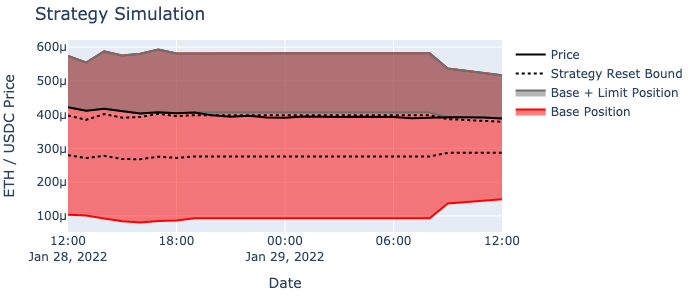

In [21]:

resulting_strat    = simulated_strategy
resulting_data     = ActiveStrategyFramework.generate_simulation_series(resulting_strat,ML_S)
p                  = ActiveStrategyFramework.plot_strategy(resulting_data,'ETH / USDC Price')

In [8]:
strat_result

{'days_strategy': 0,
 'gross_fee_apr': inf,
 'gross_fee_return': 8.050416594357343e-06,
 'net_apr': inf,
 'net_return': 0.011750795243774093,
 'rebalances': 1,
 'max_drawdown': 0.011614317773719091,
 'volatility': nan,
 'sharpe_ratio': nan,
 'impermanent_loss': -0.00012800743352857466,
 'mean_base_position': 0.6334196029932196,
 'median_base_position': 0.6334196029932196,
 'mean_base_width': 1.1090626066766216,
 'median_base_width': 1.1090626066766216,
 'final_value': 202350.15904875484}

In [6]:
#################
#
# Run ML Strategy
#
################

# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2022-01-15 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2022-01-28 00:00PM',utc=True)
z_score_cutoff             = 5
window_size                = 60

# Data for strategy simulation cleaning 
STRATEGY_FREQUENCY                      = 'H'
simulate_data_filtered                   = ActiveStrategyFramework.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size) 
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_price                      = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]


# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
STAT_MODEL_FREQUENCY       = 'H' # forecast returns at a daily frequency

# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*(10**((DECIMALS_1  + DECIMALS_0)/2))
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

# Strategy Parameters
alpha_range      = [.50,.75]
tau_range        = [.25,0.75]
vol_range        = [0.85,.95]
sim_performance  = []
sim_results      = []
sim_data_collect = []

for j in list(itertools.product(alpha_range,tau_range,vol_range)):
    print(j)
    AR_Strategy                      = ML_Strategy.ML_Strategy(price_data,j[0],j[1],j[2],data_frequency=STAT_MODEL_FREQUENCY,z_score_cutoff=6,return_forecast_cutoff=.5)
    simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,swap_data,AR_Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
    sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,AR_Strategy)
    strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data,frequency=STRATEGY_FREQUENCY)
    strat_result['alpha_param']      = j[0]
    strat_result['tau_param']        = j[1]
    strat_result['volatility_param'] = j[2]
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)
    sim_data_collect.append(sim_data)

(0.5, 0.25, 0.85)


/Users/amir1/projects/liquidity/gamma/active-strategy-framework/feature_extraction.py:80: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  #prices_data['RSI'] = calculateRSI(prices_data).fillna(0)


ValueError: cannot reindex on an axis with duplicate labels

In [6]:
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},
           {'a': 100, 'b': 200, 'c': 300, 'd': 400},
           {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]
df = pd.DataFrame(mydict)
df

,a,b,c,d
0,1,2,3,4
1,100,200,300,400
2,1000,2000,3000,4000


In [7]:
df.iloc[-1]

a    1000
b    2000
c    3000
d    4000
Name: 2, dtype: int64

In [3]:
from datetime import datetime, timedelta

In [7]:
date_begin = pd.to_datetime(pd.DataFrame('2022-01-09'), "%Y-%m-%d",)
#date_end = datetime.strptime(config['price_data']['date_end'], format="%Y-%m-%d")

ValueError: DataFrame constructor not properly called!

In [14]:
date_begin

datetime.datetime(2022, 1, 9, 0, 0)

In [3]:
import os
import yaml


In [6]:
config_path = os.path.join('/Users/amir1/PycharmProjects/uniswap-automation/config/params_all.yaml')
config = yaml.safe_load(open(config_path))['predict']
os.chdir(config['dir_folder'])
price_data = GetPoolData.get_price_data_bitquery(**config['price_data'])

In [7]:
price_data

,time,baseCurrency,quoteCurrency,quoteAmount,baseAmount,tradeAmount,quotePrice
time_pd,,,,,,,
2022-01-09 00:00:00+00:00,2022-01-09 00:00:00,USDC,WETH,4.480939,1.380926e+04,1.381520e+04,0.000324
2022-01-09 00:01:00+00:00,2022-01-09 00:01:00,USDC,WETH,399.204123,1.228478e+06,1.229001e+06,0.000325
2022-01-09 00:02:00+00:00,2022-01-09 00:02:00,USDC,WETH,456.396520,1.402633e+06,1.403237e+06,0.000325
2022-01-09 00:03:00+00:00,2022-01-09 00:03:00,USDC,WETH,54.787702,1.685469e+05,1.685993e+05,0.000325
2022-01-09 00:04:00+00:00,2022-01-09 00:04:00,USDC,WETH,171.068322,5.253861e+05,5.256123e+05,0.000326
...,...,...,...,...,...,...,...
2022-01-09 23:56:00+00:00,2022-01-09 23:56:00,USDC,WETH,98.232538,3.089074e+05,3.090113e+05,0.000318
2022-01-09 23:57:00+00:00,2022-01-09 23:57:00,USDC,WETH,63.727175,2.006837e+05,2.007512e+05,0.000318
2022-01-09 23:58:00+00:00,2022-01-09 23:58:00,USDC,WETH,1.903027,6.000000e+03,6.002019e+03,0.000317


In [20]:
config['price_data']

{'DOWNLOAD_DATA': False,
 'api_token': 'BQY0mSI2IadezoknHO3JMzexNwCpugm5',
 'date_begin': '2021-12-31',
 'date_end': '2022-01-10',
 'file_name': 'eth_usdc',
 'token_0_address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
 'token_1_address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'}

In [6]:
brakets_dates = pd.DataFrame(data=[config['price_data']['date_begin'], config['price_data']['date_end']])

In [7]:
brakets_dates['time'] = pd.to_datetime(brakets_dates[0], format="%Y-%m-%d %H:%M:%S")

In [8]:
brakets_dates["time_pd"] = pd.to_datetime(brakets_dates["time"], utc=True)

In [12]:
str(brakets_dates['time_pd'][1])

'2022-01-10 00:00:00+00:00'

In [11]:
price_data['2021-12-31 00:04:00+00:00': '2022-04-10 23:55:00+00:00']

,time,baseCurrency,quoteCurrency,quoteAmount,baseAmount,tradeAmount,quotePrice
time_pd,,,,,,,
2021-12-31 00:04:00+00:00,2021-12-31 00:04:00,USDC,WETH,12.514290,4.663761e+04,4.637888e+04,0.000268
2021-12-31 00:05:00+00:00,2021-12-31 00:05:00,USDC,WETH,100.569846,3.740993e+05,3.727193e+05,0.000269
2021-12-31 00:06:00+00:00,2021-12-31 00:06:00,USDC,WETH,118.024078,4.383876e+05,4.374059e+05,0.000269
2021-12-31 00:07:00+00:00,2021-12-31 00:07:00,USDC,WETH,3.539528,1.313758e+04,1.311775e+04,0.000269
2021-12-31 00:08:00+00:00,2021-12-31 00:08:00,USDC,WETH,307.535632,1.144060e+06,1.139669e+06,0.000269
...,...,...,...,...,...,...,...
2022-04-10 23:51:00+00:00,2022-04-10 23:51:00,USDC,WETH,132.736601,4.270925e+05,4.276613e+05,0.000311
2022-04-10 23:52:00+00:00,2022-04-10 23:52:00,USDC,WETH,342.090186,1.100054e+06,1.101615e+06,0.000311
2022-04-10 23:53:00+00:00,2022-04-10 23:53:00,USDC,WETH,245.918797,7.901940e+05,7.913391e+05,0.000311


In [13]:
price_data[str(brakets_dates['time_pd'][0]):str(brakets_dates['time_pd'][1])]

/var/folders/tb/k2f5ty5x0gnf37jprv2lpvxc0000gn/T/ipykernel_23166/4021165356.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  price_data[str(brakets_dates['time_pd'][0]):str(brakets_dates['time_pd'][1])]


,time,baseCurrency,quoteCurrency,quoteAmount,baseAmount,tradeAmount,quotePrice
time_pd,,,,,,,
2021-12-31 00:01:00+00:00,2021-12-31 00:01:00,USDC,WETH,108.866056,4.040058e+05,4.032989e+05,0.000269
2021-12-31 00:02:00+00:00,2021-12-31 00:02:00,USDC,WETH,725.415084,2.699606e+06,2.688442e+06,0.000269
2021-12-31 00:03:00+00:00,2021-12-31 00:03:00,USDC,WETH,10.911621,4.067962e+04,4.043927e+04,0.000268
2021-12-31 00:04:00+00:00,2021-12-31 00:04:00,USDC,WETH,12.514290,4.663761e+04,4.637888e+04,0.000268
2021-12-31 00:05:00+00:00,2021-12-31 00:05:00,USDC,WETH,100.569846,3.740993e+05,3.727193e+05,0.000269
...,...,...,...,...,...,...,...
2022-01-09 23:56:00+00:00,2022-01-09 23:56:00,USDC,WETH,98.232538,3.089074e+05,3.090113e+05,0.000318
2022-01-09 23:57:00+00:00,2022-01-09 23:57:00,USDC,WETH,63.727175,2.006837e+05,2.007512e+05,0.000318
2022-01-09 23:58:00+00:00,2022-01-09 23:58:00,USDC,WETH,1.903027,6.000000e+03,6.002019e+03,0.000317
